In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####  Pytorch ImageFolder 객체에 맞도록 datafolder 구성 (레이블 필요한 경우)

In [ ]:
# filename 에 class 가 바로 대응된 dictionary 파일 읽어옴
import pickle

# dataset에서 file들 가져옴 
import os
import shutil

with open('/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/pFileNameToClass.pickle','rb') as fw:
    pFileNameToClass = pickle.load(fw) # O(1) 로 바로 class 찾을 수 있다.

# 인쇄체 데이터 모은 폴더의 이미지들 file list 받음
path = "/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/printed"
file_list = os.listdir(path) # 35765 -> augmentation 필요

# imageFolder 객체에 맞도록 datafolder 구성
pretrain_dir_path = "/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/pretrainDataset"
os.makedirs(pretrain_dir_path, exist_ok=True)

for filename in file_list:
    label = pFileNameToClass[filename]
    folder_path = "/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/pretrainDataset/" + str(label)
    os.makedirs(folder_path, exist_ok=True)
    shutil.move(path + '/' + filename, folder_path + '/' + filename)

#### OSError: errno 5 input/output error 해결하기

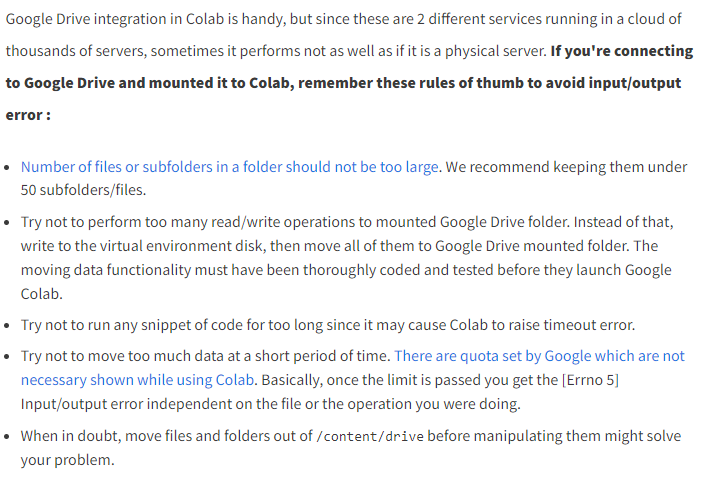

In [ ]:
import os
import shutil

# colab VM disc 사용
dir_path = "/content/data/printed"
os.makedirs(dir_path, exist_ok=True)

# 공유 드라이브의 데이터를 복사해 생성하기
driveFolder = '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/printed'
newFolder = '/content/data/printed'
shutil.copytree(driveFolder, newFolder)

OSError: ignored

In [ ]:
path = "/content/data/printed"
file_list = os.listdir(path) # 35765 -> augmentation 필요
len(file_list)

0

## DataPreprocessing and DataAugmentation

In [2]:
!unzip '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/transfer/myData.zip' -d ./data

Archive:  /content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/transfer/myData.zip
replace ./data/myData/1_000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./data/myData/1_000.png  
 extracting: ./data/myData/1_001.png  
  inflating: ./data/myData/1_002.png  
  inflating: ./data/myData/1_003.png  
  inflating: ./data/myData/1_004.png  
  inflating: ./data/myData/1_005.png  
  inflating: ./data/myData/1_006.png  
  inflating: ./data/myData/1_007.png  
  inflating: ./data/myData/1_008.png  
  inflating: ./data/myData/1_009.png  
  inflating: ./data/myData/1_010.png  
  inflating: ./data/myData/1_011.png  
  inflating: ./data/myData/1_012.png  
  inflating: ./data/myData/1_013.png  
  inflating: ./data/myData/1_014.png  
 extracting: ./data/myData/1_015.png  
 extracting: ./data/myData/1_016.png  
  inflating: ./data/myData/1_017.png  
 extracting: ./data/myData/1_018.png  
  inflating: ./data/myData/1_019.png  
  inflating: ./data/myData/

#### data preprocessing : 여백 최소화

./data/myData/9_71.png Size: (121, 120) New Size: (1, 15, 52, 95)
original Image : 


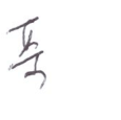

cropped Image : 


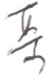

In [7]:
from PIL import Image, ImageOps

filePath = './data/myData/9_71.png' 
image=Image.open(filePath)
image.load()
imageSize = image.size

# remove alpha channel
invert_im = image.convert("RGB") 

# invert image (so that white is 0)
invert_im = ImageOps.invert(invert_im)
imageBox = invert_im.getbbox()

cropped=image.crop(imageBox)
print(filePath, "Size:", imageSize, "New Size:", imageBox)

print("original Image : ")
display(image)
print("cropped Image : ")
display(cropped)

#### data augmentation : 회전, 밝기, 대비, 채도, 색조

In [8]:
import numpy as np
import scipy
import scipy.ndimage
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
import collections
from PIL import Image
import numbers

In [9]:
class RandomRotate(object):
    """Rotate a PIL.Image or numpy.ndarray (H x W x C) randomly
    """

    def __init__(self, angle_range=(-20.0, 20.0), axes=(0, 1), mode='reflect', random_state=np.random):
        assert isinstance(angle_range, tuple)
        self.angle_range = angle_range
        self.random_state = random_state
        self.axes = axes
        self.mode = mode

    def __call__(self, image):
        angle = self.random_state.uniform(
            self.angle_range[0], self.angle_range[1])
        if isinstance(image, np.ndarray):
            mi, ma = image.min(), image.max()
            image = scipy.ndimage.interpolation.rotate(
                image, angle, reshape=False, axes=self.axes, mode=self.mode)
            return np.clip(image, mi, ma)
        elif isinstance(image, Image.Image):
            return image.rotate(angle)
        else:
            raise Exception('unsupported type')

    def __name__(self):
        return "Rotation"

original : 


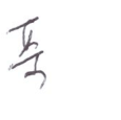

augmented : 


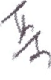

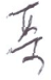

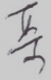

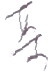

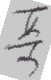

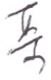

In [10]:
from PIL import Image
from torchvision import transforms

rotate1 = RandomRotate(angle_range=(0, 20.0))
rotate2 = RandomRotate(angle_range=(-20.0, 0))
# 0.5 ~1.5 범위  밝기, 대비, 채도, 색조
bright_aug = transforms.ColorJitter(brightness=0.3)

rotate_bright_aug1 = transforms.Compose([bright_aug, rotate1])
rotate_bright_aug2 = transforms.Compose([bright_aug, rotate2])

contrast_aug = transforms.ColorJitter(contrast=0.5)

samplePath = './data/myData/9_71.png' 
sample = Image.open(samplePath)
sample = sample.convert("RGB") 
print("original : ")
display(sample)

print("augmented : ")
for i, transform_ in enumerate([rotate1, rotate2, bright_aug, rotate_bright_aug1, rotate_bright_aug2, contrast_aug]):
    # sample = Image.open(samplePath) 
    transformed = transform_(cropped)
    display(transformed)

#### data preprocessing and augmenting

In [11]:
import numpy as np
import scipy
import scipy.ndimage
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
import collections
from PIL import Image
import numbers

class RandomRotate(object):
    """Rotate a PIL.Image or numpy.ndarray (H x W x C) randomly
    """

    def __init__(self, angle_range=(-20.0, 20.0), axes=(0, 1), mode='reflect', random_state=np.random):
        assert isinstance(angle_range, tuple)
        self.angle_range = angle_range
        self.random_state = random_state
        self.axes = axes
        self.mode = mode

    def __call__(self, image):
        angle = self.random_state.uniform(
            self.angle_range[0], self.angle_range[1])
        if isinstance(image, np.ndarray):
            mi, ma = image.min(), image.max()
            image = scipy.ndimage.interpolation.rotate(
                image, angle, reshape=False, axes=self.axes, mode=self.mode)
            return np.clip(image, mi, ma)
        elif isinstance(image, Image.Image):
            return image.rotate(angle)
        else:
            raise Exception('unsupported type')

    def __name__(self):
        return "Rotation"

In [12]:
from torchvision import transforms

rotate1 = RandomRotate(angle_range=(0, 10.0))
rotate2 = RandomRotate(angle_range=(-10.0, 0))
# 0.5 ~1.5 범위  밝기, 대비, 채도, 색조
bright_aug = transforms.ColorJitter(brightness=0.2)

rotate_bright_aug1 = transforms.Compose([bright_aug, rotate1])
rotate_bright_aug2 = transforms.Compose([bright_aug, rotate2])

contrast_aug = transforms.ColorJitter(contrast=0.5)

# saturation_aug = transforms.ColorJitter(saturation=0.5)
# hue_aug = transforms.ColorJitter(hue=0.5) 

augmentation 이전 데이터 수 :  997
augmentation 이후 데이터 수 :  6979


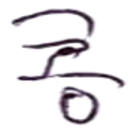

In [13]:
import os
path = '/content/data/myData'
file_list_ = os.listdir(path)

print("augmentation 이전 데이터 수 : ", len(file_list_))

savePath = '/content/data/augmentedData'
if not os.path.exists(savePath):
    os.makedirs(savePath)

for filename in file_list_:
    filePath = path + '/' + filename
    image=Image.open(filePath)
    image.load()
    imageSize = image.size
    
    # # 여백 제거
    # remove alpha channel
    invert_im = image.convert("RGB") 
    # invert image (so that white is 0)
    invert_im = ImageOps.invert(invert_im)
    imageBox = invert_im.getbbox()
    cropped=image.crop(imageBox)

    # display(cropped)

    # 정사각형 꼴로 변환 
    width , height = cropped.width, cropped.height 
    size = width if width > height else height
    cropped = cropped.resize((size, size))

    # display(cropped)

    # cropped 이미지 저장 
    cropped.convert("RGB").resize((128,128)).save(savePath + '/' + filename)

    for i, transform_ in enumerate([rotate1, rotate2, bright_aug, rotate_bright_aug1, rotate_bright_aug2, contrast_aug]):
        transformed = transform_(cropped).convert("RGB").resize((128,128))
        # augmented 이미지 저장
        transformed.save(f"{savePath}/{i}_{filename}")
    

path = '/content/data/augmentedData'
file_list_ = os.listdir(path)
print("augmentation 이후 데이터 수 : ", len(file_list_))
display(transformed)

#### zip 파일에 저장 - 구글 드라이브 저장용

In [14]:
import zipfile

new_zips= zipfile.ZipFile('preprocessed_augmented_myData.zip', 'w') # 
num_zipfile = 0

for folder, subfolders, files in os.walk('/content/data/augmentedData'): 
    for file in files:
        new_zips.write(os.path.join(folder, file), os.path.relpath(os.path.join(folder,file), './'), compress_type = zipfile.ZIP_DEFLATED)
        num_zipfile += 1
new_zips.close()

print("저장한 데이터 수 : ", num_zipfile)

저장한 데이터 수 :  6979


#### zip파일을 구글 드라이브에 이동

In [16]:
import shutil

savePath = '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/transfer'

shutil.move('preprocessed_augmented_myData.zip', savePath)

'/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/transfer/preprocessed_augmented_myData.zip'

### github 커밋

In [17]:
MY_GOOGLE_DRIVE_PATH = "/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital"
%cd "{MY_GOOGLE_DRIVE_PATH}"

/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital


In [18]:
!git config --global user.email dkwjd0824@khu.ac.kr  # 이메일 입력 ex) qhrqufdlek@naver.com
!git config --global user.name  hyeneung #깃헙 아이디 입력 ex)luckydipper
!git pull

Already up to date.


In [19]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   GAN/Parsing.ipynb
	modified:   GAN/WGAN_DIV.ipynb
	modified:   GAN/model/SelfAttention_Wasserstein/discriminator.pth
	modified:   GAN/model/SelfAttention_Wasserstein/generator.pth
	modified:   GAN/myDataDataset.ipynb
	modified:   GAN/selfAttentionGAN.ipynb
	modified:   GAN/transferLearning.ipynb
	deleted:    "object_detection/20211119 \341\204\211\341\205\265\341\206\257\341\204\214\341\205\245\341\206\253\341\204\200\341\205\265\341\204\200\341\205\250\341\204\222\341\205\241\341\206\250\341\204\211\341\205\263\341\206\270 \341\204\211\341\205\265\341\206\257\341\204\211\341\205\263\341\206\270 \341\204\217\341\205\251\341\204\203\341\205\263 (1).ipynb"
	deleted:    "object_detection/20211119 \354\213\244\354\240\204\352\270\260\352\263\204\3

In [ ]:
!git add GAN/transferLearning.ipynb GAN/myDataDataset.ipynb

In [ ]:
!git commit -m"[ADD] padding and reshaping"

[main af895be] [ADD] padding and reshaping
 2 files changed, 2 insertions(+), 1 deletion(-)
 create mode 100644 GAN/transferLearning.ipynb


In [ ]:
!git push

Counting objects: 5, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 165.87 KiB | 5.35 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/PILGI-Analog-To-Digital/Analog-PILGI-to-DIgital.git
   0100ed6..af895be  main -> main
